In [1]:
from lerobot.common.datasets.lerobot_dataset import (
    LeRobotDataset,
    LeRobotDatasetMetadata,
)
from torch.utils.data import DataLoader
from gym_av_aloha.common.replay_buffer import ReplayBuffer
from torchvision.transforms import Resize
import torch
import os
import numpy as np
from tqdm import tqdm

/Users/ianc/miniconda3/envs/gym_av_aloha/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
repo_id = "iantc104/av_aloha_sim_peg_insertion"
image_size = (480, 640)

In [3]:
zarr_path = os.path.join("outputs", repo_id)
replay_buffer = ReplayBuffer.create_from_path(zarr_path=zarr_path, mode="a")

ds_meta = LeRobotDatasetMetadata(repo_id)
replay_buffer.update_meta({
    "repo_id": ds_meta.repo_id,
})

<zarr.hierarchy.Group '/meta'>

In [8]:
def convert(k, v: torch.Tensor, ds_meta: LeRobotDatasetMetadata):
    dtype = ds_meta.features[k]['dtype']
    if dtype in ['image', 'video']:
        v = Resize(image_size)(v)
        # (B, C, H, W) to (B, H, W, C)
        v = v.permute(0, 2, 3, 1)
        # convert from torch float32 to numpy uint8
        v = (v * 255).to(torch.uint8).numpy()
    else:
        v = v.numpy()
    return v

# iterate through dataset
for i in tqdm(range(ds_meta.total_episodes)):
    dataset = LeRobotDataset(repo_id, episodes=[i])
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    batch = next(iter(dataloader))  # Fetches the batch
    batch = {k:convert(k,v,ds_meta) for k,v in batch.items() if k in ds_meta.features}
    
    episode_id = replay_buffer.n_episodes
    replay_buffer.add_episode(batch, compressors='disk')


  2%|▏         | 1/50 [00:15<12:45, 15.62s/it]


KeyboardInterrupt: 

In [4]:
from gym_av_aloha.common.replay_buffer import ReplayBuffer
from typing import Dict
from lerobot.common.datasets.utils import (
    check_delta_timestamps,
    get_delta_indices,
    get_episode_data_index,
    check_timestamps_sync,
)


class AVAlohaImageDataset(torch.utils.data.Dataset):
    def __init__(self,
            zarr_path: str | None = None,
            delta_timestamps: dict[list[float]] | None = None,
            tolerance_s: float = 1e-4,
            episodes: list[int] | None = None,
        ):
        super().__init__()
        self.zarr_path = zarr_path
        self.delta_timestamps = delta_timestamps
        self.tolerance_s = tolerance_s
        self.episodes = episodes
        
        self.replay_buffer = ReplayBuffer.copy_from_path(self.zarr_path)
        repo_id = str(np.array(self.replay_buffer.meta['repo_id']))
        self.ds_meta = LeRobotDatasetMetadata(repo_id)

        self.episode_data_index = get_episode_data_index({
            i: {
                'episode_index': i,
                'length': length
            }
            for i, length in enumerate(self.replay_buffer.episode_lengths)
        }, self.episodes)

        # Check timestamps
        timestamps = np.array(self.replay_buffer['timestamp'])
        episode_indices = np.array(self.replay_buffer['episode_index'])
        ep_data_index_np = {k: t.numpy() for k, t in self.episode_data_index.items()}
        check_timestamps_sync(timestamps, episode_indices, ep_data_index_np, self.fps, self.tolerance_s)

        if self.delta_timestamps is not None:
            check_delta_timestamps(self.delta_timestamps, self.fps, self.tolerance_s)
            self.delta_indices = get_delta_indices(self.delta_timestamps, self.fps)

        
    def _get_query_indices(self, idx: int, ep_idx: int) -> tuple[dict[str, list[int | bool]]]:
        ep_start = self.episode_data_index["from"][ep_idx]
        ep_end = self.episode_data_index["to"][ep_idx]
        query_indices = {
            key: [max(ep_start.item(), min(ep_end.item() - 1, idx + delta)) for delta in delta_idx]
            for key, delta_idx in self.delta_indices.items()
        }
        padding = {  # Pad values outside of current episode range
            f"{key}_is_pad": torch.BoolTensor(
                [(idx + delta < ep_start.item()) | (idx + delta >= ep_end.item()) for delta in delta_idx]
            )
            for key, delta_idx in self.delta_indices.items()
        }
        return query_indices, padding
    
    def _query_replay_buffer(self, query_indices: dict[str, list[int]]) -> dict:
        return {
            key: self.replay_buffer[key][q_idx]
            for key, q_idx in query_indices.items()
        }

    @property
    def stats(self):
        return self.ds_meta.stats
    
    @property
    def features(self):
        return self.ds_meta.features
    
    @property
    def fps(self):
        return self.ds_meta.fps
    
    @property
    def total_episodes(self):
        return len(self.episodes)
    
    @property
    def video_keys(self):
        return self.ds_meta.video_keys
    
    @property
    def image_keys(self):
        return self.ds_meta.image_keys

    def __len__(self) -> int:
        return self.replay_buffer.n_steps
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        ep_idx = self.replay_buffer["episode_index"][idx]
        item = {"episode_index": torch.tensor(ep_idx)}
        
        query_indices, padding = self._get_query_indices(idx, ep_idx)
        query_result = self._query_replay_buffer(query_indices)
        item = {**item, **padding}
        for key, val in query_result.items():
            if key in self.image_keys or key in self.video_keys:
                item[key] = torch.from_numpy(val).type(torch.float32).permute(0, 3, 1, 2) / 255.0
            else:
                item[key] = torch.from_numpy(val)

        return item

In [6]:
import time

delta_timestamps = {
    "observation.images.zed_cam_left": [t / ds_meta.fps for t in range(1 - 2, 1)],
    "observation.images.zed_cam_right": [t / ds_meta.fps for t in range(1 - 2, 1)],
    "observation.images.wrist_cam_left": [t / ds_meta.fps for t in range(1 - 2, 1)],
    "observation.images.wrist_cam_right": [t / ds_meta.fps for t in range(1 - 2, 1)],
    "observation.images.worms_eye_cam": [t / ds_meta.fps for t in range(1 - 2, 1)],
    "observation.images.overhead_cam": [t / ds_meta.fps for t in range(1 - 2, 1)],
    "observation.state": [t / ds_meta.fps for t in range(1 - 2, 1)],
    # "observation.state": [t / ds_meta.fps for t in range(1 - 10, 1)],
    "action": [t / ds_meta.fps for t in range(16)],
}

# Create the AVAlohaImageDataset
zarr_path = os.path.join("outputs", repo_id)
zarr_dataset = AVAlohaImageDataset(zarr_path=zarr_path, delta_timestamps=delta_timestamps)
zarr_dataloader = DataLoader(zarr_dataset, batch_size=32, shuffle=True)

lerobot_dataset = LeRobotDataset(repo_id, delta_timestamps=delta_timestamps)
lerobot_dataloader = DataLoader(lerobot_dataset, batch_size=32, shuffle=True)


print("Testing zarr dataset")
avg_time = 0
for i in range(10):
    start_time = time.time()
    zarr_batch = next(iter(zarr_dataloader))
    end_time = time.time()
    avg_time += (end_time - start_time)

print(f"Zarr dataset average time per batch: {avg_time / 64:.4f} seconds")

print("Testing lerobot dataset")
avg_time = 0
for i in range(10):
    start_time = time.time()
    lerobot_batch = next(iter(lerobot_dataloader))
    end_time = time.time()
    avg_time += (end_time - start_time)
print(f"Lerobot dataset average time per batch: {avg_time / 64:.4f} seconds")

Testing zarr dataset
Zarr dataset average time per batch: 0.0092 seconds
Testing lerobot dataset


objc[13560]: Class AVFFrameReceiver is implemented in both /Users/ianc/miniconda3/envs/gym_av_aloha/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x12b4a83a8) and /Users/ianc/miniconda3/envs/gym_av_aloha/lib/libavdevice.60.3.100.dylib (0x162abc800). One of the two will be used. Which one is undefined.
objc[13560]: Class AVFAudioReceiver is implemented in both /Users/ianc/miniconda3/envs/gym_av_aloha/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x12b4a83f8) and /Users/ianc/miniconda3/envs/gym_av_aloha/lib/libavdevice.60.3.100.dylib (0x162abc850). One of the two will be used. Which one is undefined.


Lerobot dataset average time per batch: 0.2111 seconds


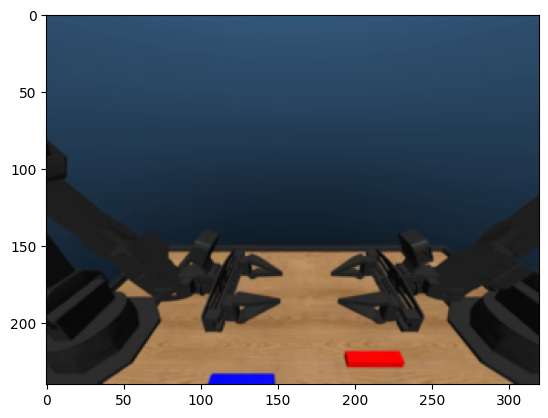

In [7]:
zarr_dataset[0]['observation.images.zed_cam_left'][0].shape

import matplotlib.pyplot as plt
plt.imshow(zarr_dataset[0]['observation.images.zed_cam_left'][0].permute(1, 2, 0))